#Bibliotecas necessárias

In [24]:
!pip install emoji

In [25]:
import os
import pandas as pd
import numpy as np
import kagglehub
import re
import unicodedata
import emoji

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Carregamento e Limpeza dos dados

In [28]:
# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment140' dataset.
Path to dataset files: /kaggle/input/sentiment140


In [29]:
df = pd.read_csv(os.path.join(path, "training.1600000.processed.noemoticon.csv"), encoding='latin-1', header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [30]:
print(df['target'].value_counts())

target
0    800000
4    800000
Name: count, dtype: int64


In [31]:
def clean_text(text):
    if pd.isna(text): return
    text = text.lower()

    # 1. Remoções de ruído típico (URLs, Menções, Hashtags)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#', ' ', text)

    # 2. Remoção de Emojis e Emoticons (Universais)
    text = emoji.replace_emoji(text, replace=' ')      # Emojis Unicode
    emoticon_pattern = re.compile(r'(\:\s?o\s?)|(\:\s?p\s?)|(\s:\s?D\s?)|(\s\s?:\s?\)|\s\s?:\s?\(|\s\s?;\s?\))|(\s\s?=\s?\))|(\s\s?=\s?\()', re.IGNORECASE)
    text = emoticon_pattern.sub(r' ', text)

    # 3. Remoção de Caracteres Especiais/Pontuação
    text = re.sub(r'[^a-z0-9!?\s]', ' ', text)

    # 4. Finalização (Espaços múltiplos)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [32]:
#Nova df para limpeza
dados_limpos = df[['target', 'text']].copy()

#Aplicando função de limpeza
dados_limpos['clean_text'] = dados_limpos['text'].apply(clean_text)

#inserindo nova coluna limpa
dados_limpos = dados_limpos.drop(columns=['text'])
dados_limpos = dados_limpos.rename(columns={'clean_text': 'text'})

dados_limpos['target'] = dados_limpos['target'].replace(4, 1)

In [33]:
dados_limpos

,target,text
0,0,awww that s a bummer you shoulda got david car...
1,0,is upset that he can t update his facebook by ...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i h...
...,...,...
1599995,4,just woke up having no school is the best feel...
1599996,4,thewdb com very cool to hear old walt interviews!
1599997,4,are you ready for your mojo makeover? ask me f...
1599998,4,happy 38th birthday to my boo of alll time!!! ...


#Criando o Pipeline TF-IDF + Regressão Logística

In [34]:
# X (Features) é o texto limpo
X = dados_limpos['text']

# y (Target) é o sentimento (0 ou 1)
y = dados_limpos['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino (X_train): {len(X_train)}")
print(f"Tamanho do conjunto de teste (X_test): {len(X_test)}")

Tamanho do conjunto de treino (X_train): 1120000
Tamanho do conjunto de teste (X_test): 480000


In [35]:
# 1. Definir os passos (steps)
# Passo 1: TF-IDF
tfidf_step = ('tfidf', TfidfVectorizer(
    min_df=5,               # Palavra precisa aparecer em pelo menos 5 documentos
    max_df=0.8,             # Ignora palavras que aparecem em mais de 80% dos documentos
    ngram_range=(1, 2)      # Usa palavras únicas (unigramas) e pares de palavras (bigramas)
))

# Passo 2: Classificador
lr_step = ('lr', LogisticRegression(
    solver='liblinear',     # Algoritmo bom para datasets grandes e pequenos
    C=1.0,                  # Parâmetro de regularização
    max_iter=1000,
    n_jobs=-1               # Usa todos os núcleos da CPU disponíveis
))

# 2. Construir o Pipeline
model_pipeline = Pipeline(steps=[tfidf_step, lr_step])

print("\nPipeline Criado com Sucesso:")
print(model_pipeline)


Pipeline Criado com Sucesso:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
                ('lr',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    solver='liblinear'))])


In [36]:
print("\nIniciando o treinamento do Pipeline...")
# O treinamento pode demorar um pouco devido ao tamanho do dataset (1.6M de tweets)
model_pipeline.fit(X_train, y_train)
print("✅ Treinamento concluído!")


Iniciando o treinamento do Pipeline...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


✅ Treinamento concluído!


#Resultados

--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    240000
           1       0.82      0.83      0.82    240000

    accuracy                           0.82    480000
   macro avg       0.82      0.82      0.82    480000
weighted avg       0.82      0.82      0.82    480000


--- MATRIZ DE CONFUSÃO ---


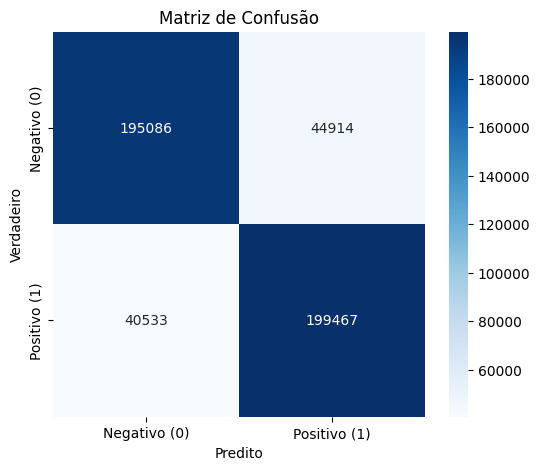

In [37]:
 # 1. Fazer previsões no conjunto de teste
y_pred = model_pipeline.predict(X_test)

# 2. Relatório de Classificação
print("--- RELATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test, y_pred))

# 3. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo (0)', 'Positivo (1)'],
            yticklabels=['Negativo (0)', 'Positivo (1)'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()